## Calculate descriptive statistics

In [1]:
import re
import math
import json
import numpy as np
import pandas as pd

In [2]:
# calculate mean, standard deviation, upper and lower bounds in confidence intervals for population size, the proportion of cooperators, average degree of cooperation, and range size

def OrgResVar(file_path, output_path=None):
    input = pd.read_csv(file_path).replace(-1, np.nan)

    colnames = ["coop_efficiency", "cost_rate", "sociality", 
                "res_mean", "res_var_range", "res_sd",
                "pop_size_mean", "pop_size_sd", "pop_size_ub", "pop_size_lb", 
                "coop_prop_mean", "coop_prop_sd", "coop_prop_ub", "coop_prop_lb", 
                "coop_deg_mean", "coop_deg_sd", "coop_deg_ub", "coop_deg_lb", 
                "range_size_mean", "range_size_sd", "range_size_ub", "range_size_lb"]

    df = pd.DataFrame(np.zeros([input.res_var_range.unique().size, len(colnames)]), columns = colnames)

    num_replic = input.replic.unique().size

    r = 0

    for i in range(input.res_var_range.unique().size):
        df.loc[i, ["coop_efficiency", "cost_rate", "sociality"]] = input.loc[r, ["coop_efficiency", "cost_rate", "sociality"]].values

        df.loc[i, "res_mean"] = input.loc[r, "res_mean"]
        df.loc[i, "res_var_range"] = input.loc[r, "res_var_range"]

        target = input[input.res_var_range == df.loc[i, "res_var_range"]]
        df.loc[i, "res_sd"] = target.res_0.std()
        
        df.loc[i, ["pop_size_mean", "coop_prop_mean", "coop_deg_mean"]] = target.loc[:, ["pop_size", "coop_prop", "aver_coop_deg"]].mean().values
        df.loc[i, ["pop_size_sd", "coop_prop_sd", "coop_deg_sd"]] = target.loc[:, ["pop_size", "coop_prop", "aver_coop_deg"]].std().values

        errs = (1.959964*df.loc[i, ["pop_size_sd", "coop_prop_sd", "coop_deg_sd"]]/math.sqrt(num_replic)).values
        df.loc[i, ["pop_size_ub", "coop_prop_ub", "coop_deg_ub"]] = df.loc[i, ["pop_size_mean", "coop_prop_mean", "coop_deg_mean"]].add(errs).values
        df.loc[i, ["pop_size_lb", "coop_prop_lb", "coop_deg_lb"]] = df.loc[i, ["pop_size_mean", "coop_prop_mean", "coop_deg_mean"]].subtract(errs).values

        group_sizes = target.loc[:, [f"pop_size_{j}" for j in range(int(re.search("res_(\d+)", input.columns[-1]).group(1)) + 1)]]
        range_size = []
        for k in range(group_sizes.shape[0]):
            range_size.append(len(group_sizes.iloc[k][group_sizes.iloc[k]>0]))
        range_size = np.array(range_size)
        df.loc[i, "range_size_mean"] = range_size.mean()
        df.loc[i, "range_size_sd"] = range_size.std()
        err = 1.959964*df.loc[i, "range_size_sd"]/math.sqrt(num_replic)
        df.loc[i,"range_size_ub"] = df.loc[i, "range_size_mean"] + err
        df.loc[i,"range_size_lb"] = df.loc[i, "range_size_mean"] - err

        r = r + num_replic

    if output_path:
        df.to_csv(output_path, index=False)
    
    return df
    

In [3]:
for sociality in ["ns", "ca", "rd"]:
    simulation_output_list_fname = f"./data/output_file_list_se_pfs_{sociality}.txt"

    with open(simulation_output_list_fname, "r") as f:
        input_list = json.load(f)

    for i, file_path in enumerate(input_list):
        df = OrgResVar(file_path)
        if i == 0:
            df_concat = df
        else:
            df_concat = pd.concat([df_concat, df], axis = 0, ignore_index=True)

    df_concat.to_csv(f"./data/social_evolution/{sociality}o_pfs_xxxxm0p0.csv", index=False)

## Plot the relationships among group benefits, the mean and variability of resources, and the evolution of cooperation (Fig. 1)

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

import utils.cmapgen.cmapgen as cg

In [2]:
def plot_heatmaps(sociality, cmap, output_path=None):   #sociality="ca" or "rd"
    df = pd.read_csv(f"./data/social_evolution/{sociality}o_pfs_xxxxm0p0.csv")

    if output_path and not os.path.exists(output_path):
        os.makedirs(output_path)

    figsize(4, 3)
    plt.rcParams.update({"font.size": 10})
    plt.rcParams["pdf.fonttype"] = 42

    plt.figure(1)
    df_cprop = df.pivot(index="res_var_range", columns="res_mean", values="coop_prop_mean")
    ax_cprop = sns.heatmap(df_cprop, vmin = 0, vmax = 1, square = True, cmap = cmap, cbar_kws={"label": "Proportion of cooperators"})
    ax_cprop.invert_yaxis()
    plt.xlabel("Mean resource availability")
    plt.ylabel("Temporal variability\n(Resource availability range)")
    if output_path:
        plt.savefig(output_path + f"{sociality}_cprop_resmean_resvarrange.pdf", format="pdf", bbox_inches="tight")

    plt.figure(2)
    df_cdeg = df.pivot(index="res_var_range", columns="res_mean", values="coop_deg_mean")
    ax_cdeg = sns.heatmap(df_cdeg, vmin = 0, vmax = 0.5, square = True, cmap = cmap, cbar_kws={"label": "Average degree of cooperation"})
    ax_cdeg.invert_yaxis()
    plt.xlabel("Mean resource availability")
    plt.ylabel("Temporal variability\n(Resource availability range)")
    if output_path:
        plt.savefig(output_path + f"{sociality}_cdeg_resmean_resvarrange.pdf", format="pdf", bbox_inches="tight")

    plt.figure(3)
    df_psize = df.pivot(index="res_var_range", columns="res_mean", values="pop_size_mean")
    ax_psize = sns.heatmap(df_psize, vmin = 0, square = True, cmap = cmap, cbar_kws={"label": "Population size"})
    ax_psize.invert_yaxis()
    plt.xlabel("Mean resource availability")
    plt.ylabel("Temporal variability\n(Resource availability range)")
    if output_path:
        plt.savefig(output_path + f"{sociality}_psize_resmean_resvarrange.pdf", format="pdf", bbox_inches="tight")

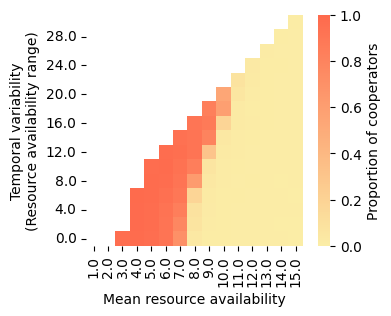

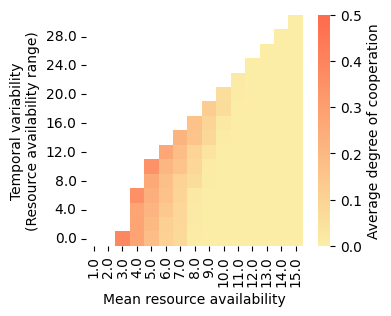

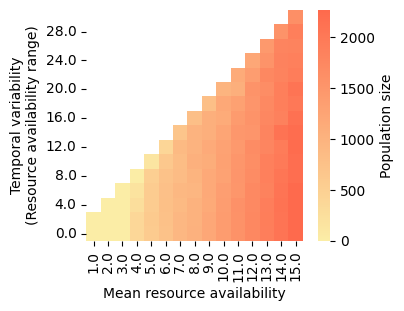

In [3]:
plot_heatmaps(sociality="ca", cmap=cg.get_continuous_cmap(["#fceea7", "#ff6a4d"]), output_path="./figures/fig_1/")

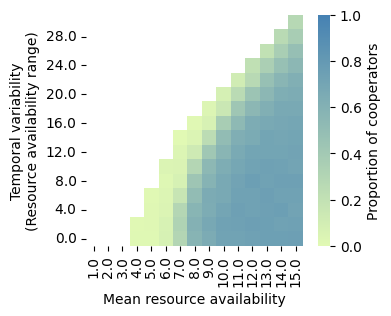

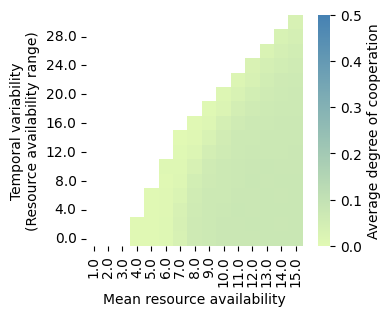

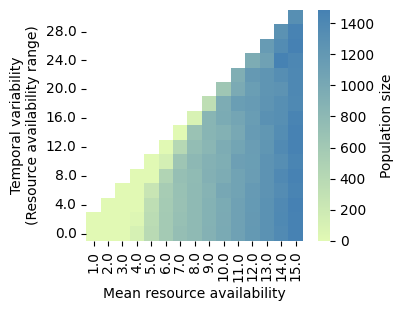

In [4]:
plot_heatmaps(sociality="rd", cmap=cg.get_continuous_cmap(["#e2fab5", "#4682b4"]), output_path="./figures/fig_1/")

## Plot the relationships among grouping benefits, the mean and variability of resources, and the ecological consequences of cooperation (Fig. 2)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def plot_pop_properties(res_mean, output_path=None):
    df_ca = pd.read_csv("./data/social_evolution/cao_pfs_xxxxm0p0.csv")
    df_rd = pd.read_csv("./data/social_evolution/rdo_pfs_xxxxm0p0.csv")
    df_ns = pd.read_csv("./data/social_evolution/nso_pfs_xxxxm0p0.csv")

    df_ca_target = df_ca[df_ca.res_mean == res_mean]
    df_rd_target = df_rd[df_rd.res_mean == res_mean]
    df_ns_target = df_ns[df_ns.res_mean == res_mean]

    if output_path and not os.path.exists(output_path):
        os.makedirs(output_path)

    plt.rcParams["pdf.fonttype"] = 42
    plt.rcParams.update({"font.size": 8})

    def plot_errorbar(df, y, color, label): # y = "coop_prop", "coop_deg", "pop_size", or "range_size"
        plt.errorbar(df.res_var_range, df[f"{y}_mean"], yerr=df[f"{y}_sd"], fmt='o', elinewidth=2, capsize=4, color=color, label=label)

    plt.figure(figsize = (3.5, 3))
    plt.ylim(-0.113, 1.7)
    plot_errorbar(df_ns_target, y="coop_prop", color="#AAAAAA", label="Nonsocial population")
    plot_errorbar(df_rd_target, y="coop_prop", color="steelBlue", label="Social population (RD)")
    plot_errorbar(df_ca_target, y="coop_prop", color="coral", label="Social population (CA)")
    plt.xlabel("Temporal variability\n(Resource availability range)")
    plt.ylabel("Proportion of cooperators")
    plt.legend(loc = 1, frameon = False)
    if output_path:
        plt.savefig(output_path + f"pfs_{res_mean}_cprop.pdf", format="pdf", bbox_inches="tight")

    plt.figure(figsize = (3.5, 3))
    plt.ylim(-0.1, 1.1)
    plot_errorbar(df_ns_target, y="coop_deg", color="#AAAAAA", label="Nonsocial population")
    plot_errorbar(df_rd_target, y="coop_deg", color="steelBlue", label="Social population (RD)")
    plot_errorbar(df_ca_target, y="coop_deg", color="coral", label="Social population (CA)")
    plt.xlabel("Temporal variability\n(Resource availability range)")
    plt.ylabel("Average degree of cooperation")
    plt.legend(loc = 1, frameon = False)
    if output_path:
        plt.savefig(output_path + f"pfs_{res_mean}_cdeg.pdf", format="pdf", bbox_inches="tight")

    plt.figure(figsize = (3.5, 3))
    plt.ylim(-200, 3000)
    plot_errorbar(df_ns_target, y="pop_size", color="#AAAAAA", label="Nonsocial population")
    plot_errorbar(df_rd_target, y="pop_size", color="steelBlue", label="Social population (RD)")
    plot_errorbar(df_ca_target, y="pop_size", color="coral", label="Social population (CA)")
    plt.xlabel("Temporal variability\n(Resource availability range)")
    plt.ylabel("Population size")
    plt.legend(loc = 1, frameon = False)
    if output_path:
        plt.savefig(output_path + f"pfs_{res_mean}_psize.pdf", format="pdf", bbox_inches="tight")

    plt.figure(figsize = (3.5, 3))
    plt.ylim(-60, 900)
    plot_errorbar(df_ns_target, y="range_size", color="#AAAAAA", label="Nonsocial population")
    plot_errorbar(df_rd_target, y="range_size", color="steelBlue", label="Social population (RD)")
    plot_errorbar(df_ca_target, y="range_size", color="coral", label="Social population (CA)")
    plt.xlabel("Temporal variability\n(Resource availability range)")
    plt.ylabel("Range size")
    plt.legend(loc = 1, frameon = False)
    if output_path:
        plt.savefig(output_path + f"pfs_{res_mean}_rsize.pdf", format="pdf", bbox_inches="tight")

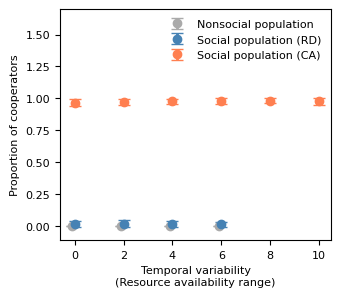

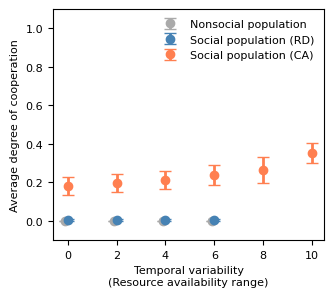

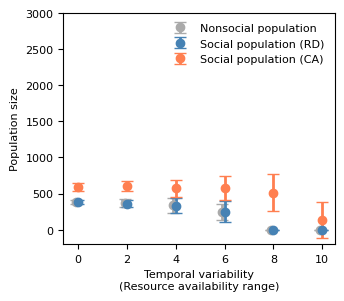

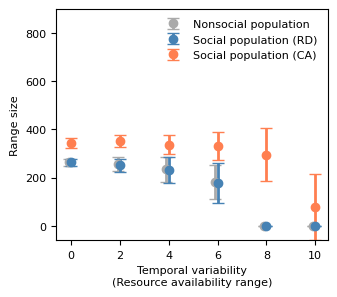

In [3]:
plot_pop_properties(res_mean=5, output_path="./figures/fig_2/")

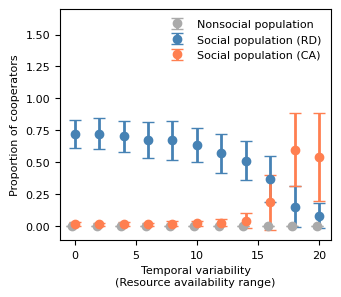

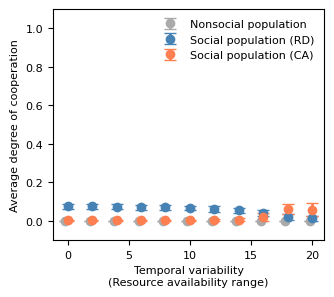

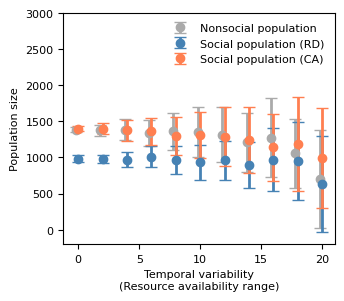

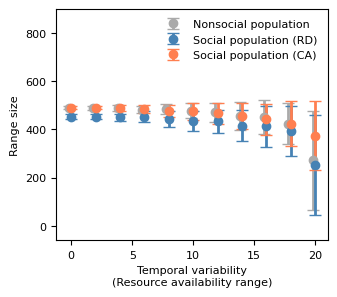

In [4]:
plot_pop_properties(res_mean=10, output_path="./figures/fig_2/")

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils.orgdata import orgpfs, myconcat
import utils.cmapgen.cmapgen as cg
import utils.plotdata.plothm as pm
import utils.plotdata.plotproperties as pp

In [12]:
def PlotGrids(fname, coop):
    df = pd.read_table(fname, header=None, sep='\t').replace(-1, np.nan)
    
    if coop:
        hexlist = ["#FFFFFF", "#ff6a4d"]
    else:
        hexlist = ["#FFFFFF", "#888888"]
    
    x = []
    for i in range(23):
        x = x + [i]*23

    p = 0

    dd = {"x":     list(range(23))*23,
          "y":     x,
          "gsize": list(df.iloc[p, range(10, 539)]),
          "prop":  list(np.array(df.iloc[p, range(539, 1068)])/np.array(df.iloc[p, range(10, 539)])),
          "deg":   list(np.array(df.iloc[p, range(1068, 1597)])/np.array(df.iloc[p, range(10, 539)])),
          "res":   list(df.iloc[p, range(1597, 2126)])}
    dfh = pd.DataFrame(dd)

    dfprop = dfh.pivot("y", "x", "gsize")
    ax = sns.heatmap(dfprop, vmin = 0, vmax = 9, square = True, cmap = cg.get_continuous_cmap(hexlist), cbar_kws={'label': 'Number of individuals'})
    plt.savefig(fname[:-4]+".pdf")

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


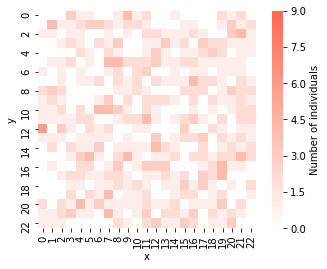

In [13]:
PlotGrids("cao_pfs_05xx.txt", True)

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


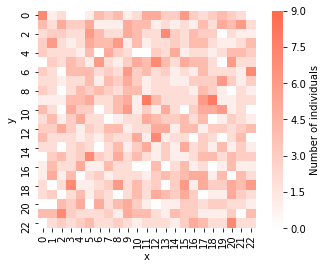

In [18]:
PlotGrids("cao_pfs_10xx.txt", True)

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


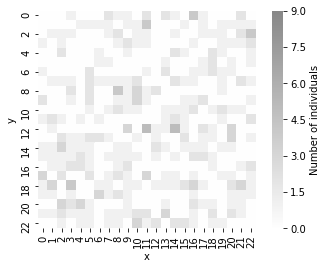

In [15]:
PlotGrids("cao_pfs_05xx0.txt", False)

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in longlong_scalars


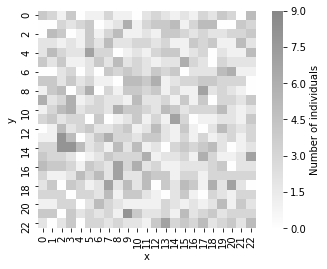

In [17]:
PlotGrids("cao_pfs_10xx0.txt", False)